## LOADING THE DATASET

In [8]:
from keras.datasets import mnist
import numpy as np

(trainImages, _), (testImages, _) = mnist.load_data()

trainImages, testImages = trainImages / 255.0, testImages / 255.0

#print("Training dimensions:", trainImages.shape)
#print("Test dimensions:", testImages.shape)

flattenedTrainImages = trainImages.reshape((trainImages.shape[0], -1))
flattenedTestImages = testImages.reshape((testImages.shape[0], -1))

print("Flattened training dimensions:", flattenedTrainImages.shape)
print("Flattened test dimensions:", flattenedTestImages.shape)

np.random.seed(42)      #To ensure that same images are used across pca and ppca. Change seed value for different images
selectedImages = np.random.choice(len(testImages), size = 5, replace=False)

Flattened training dimensions: (60000, 784)
Flattened test dimensions: (10000, 784)


## PCA IMPLEMENTATION

MSE for latent dimension 2 is: 0.05566949193442309


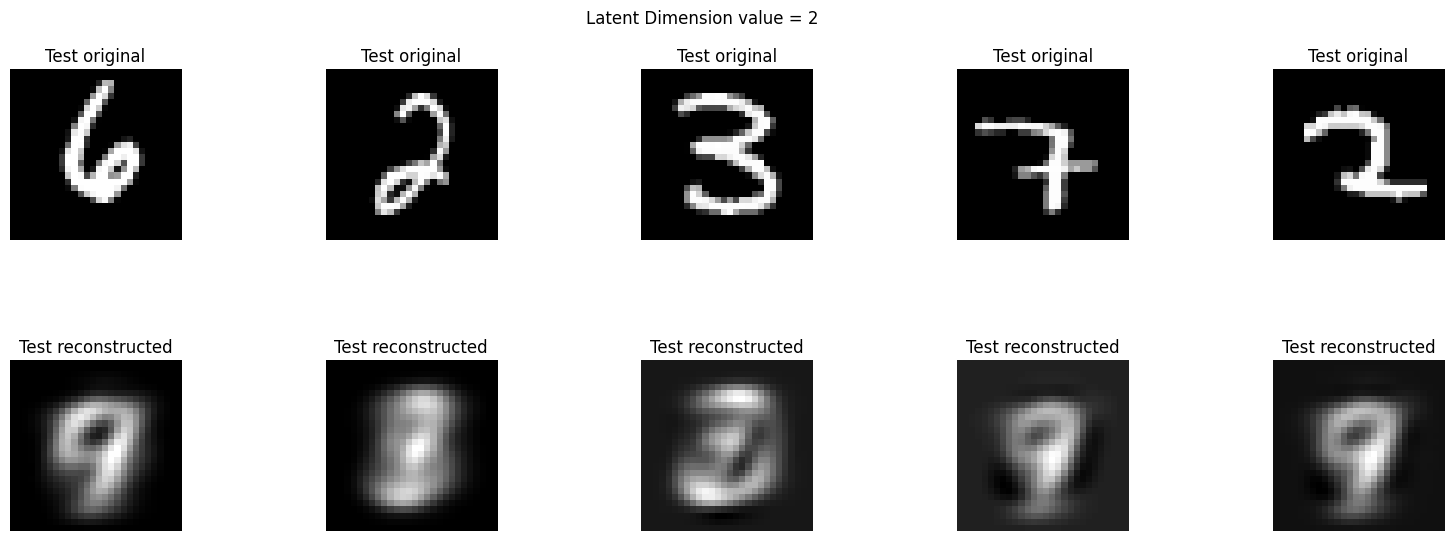

MSE for latent dimension 4 is: 0.04790346506558457


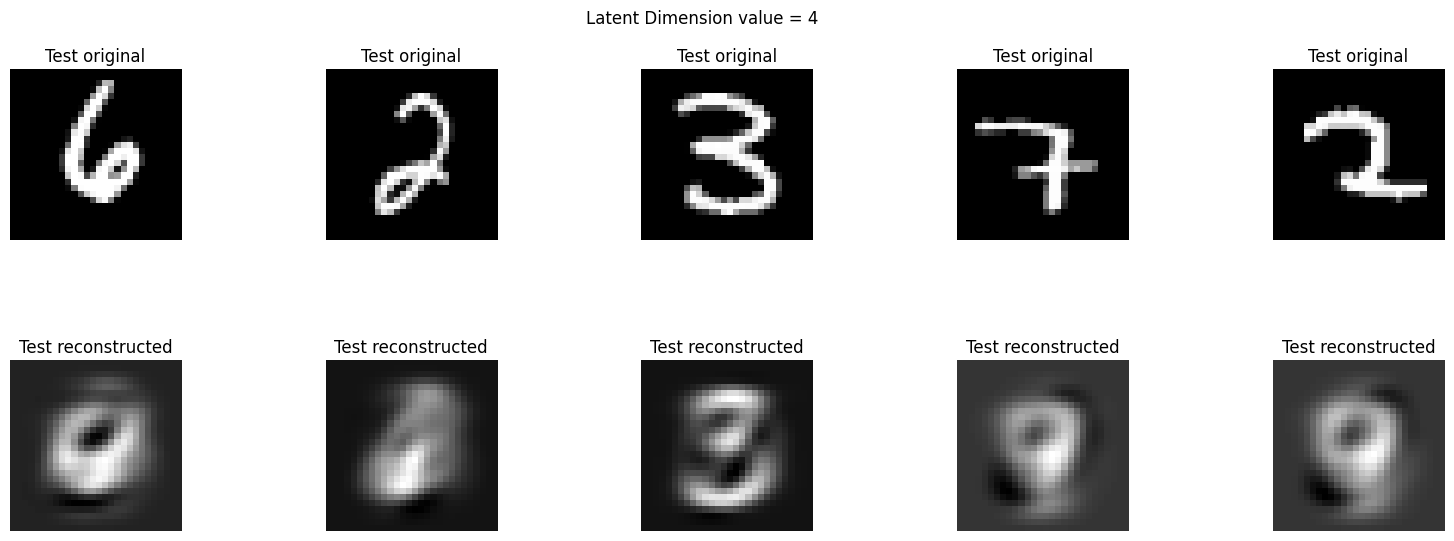

MSE for latent dimension 8 is: 0.037440933919030965


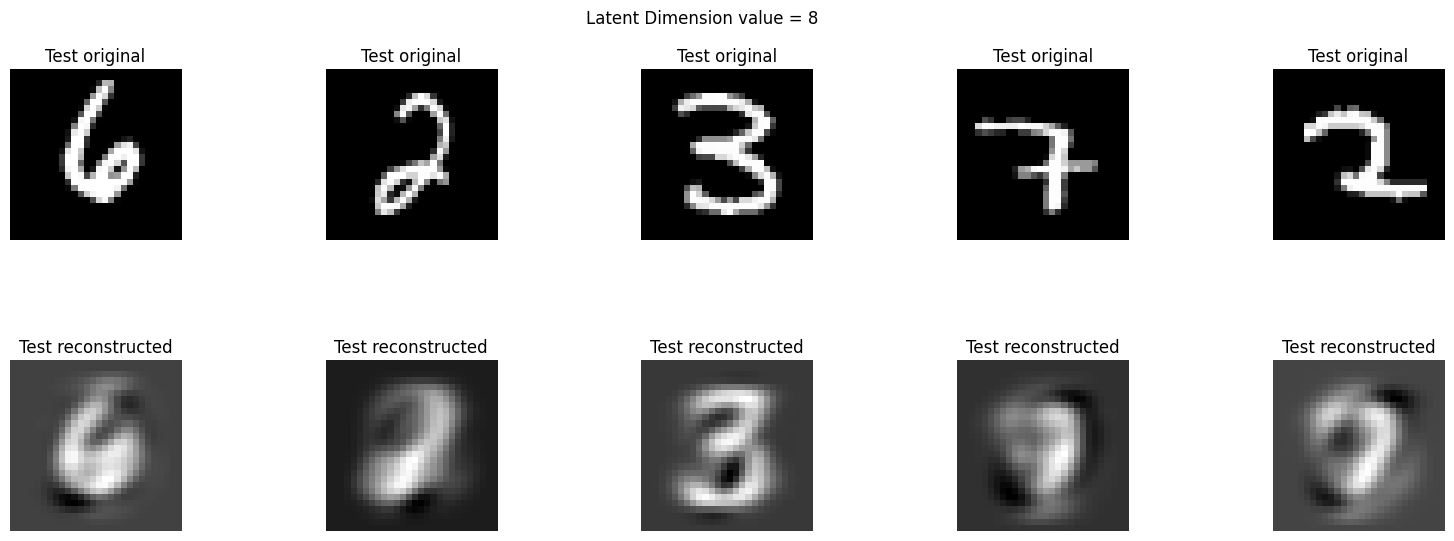

MSE for latent dimension 16 is: 0.02686019078827122


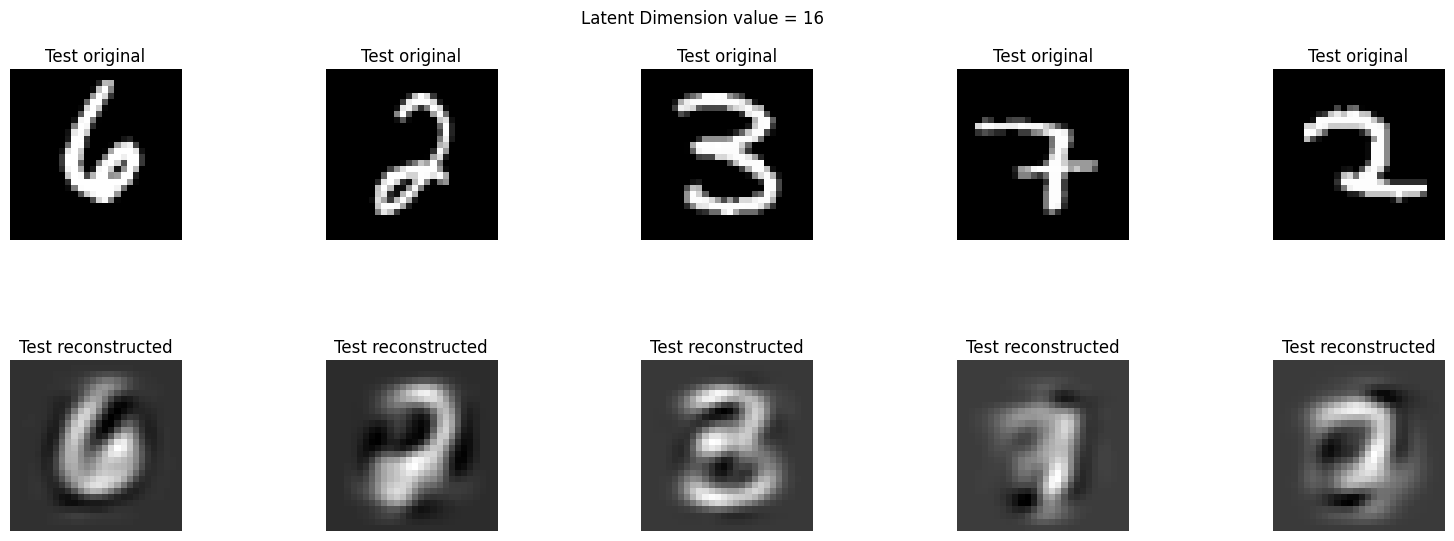

MSE for latent dimension 32 is: 0.016829987691859553


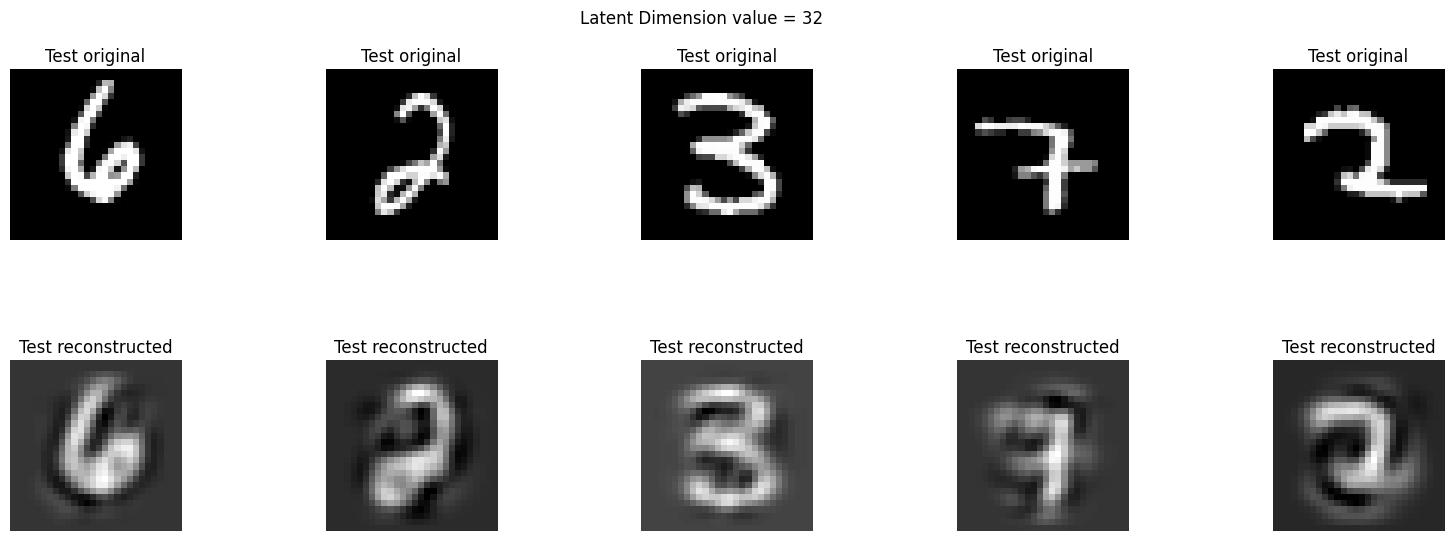

MSE for latent dimension 64 is: 0.009047770446754689


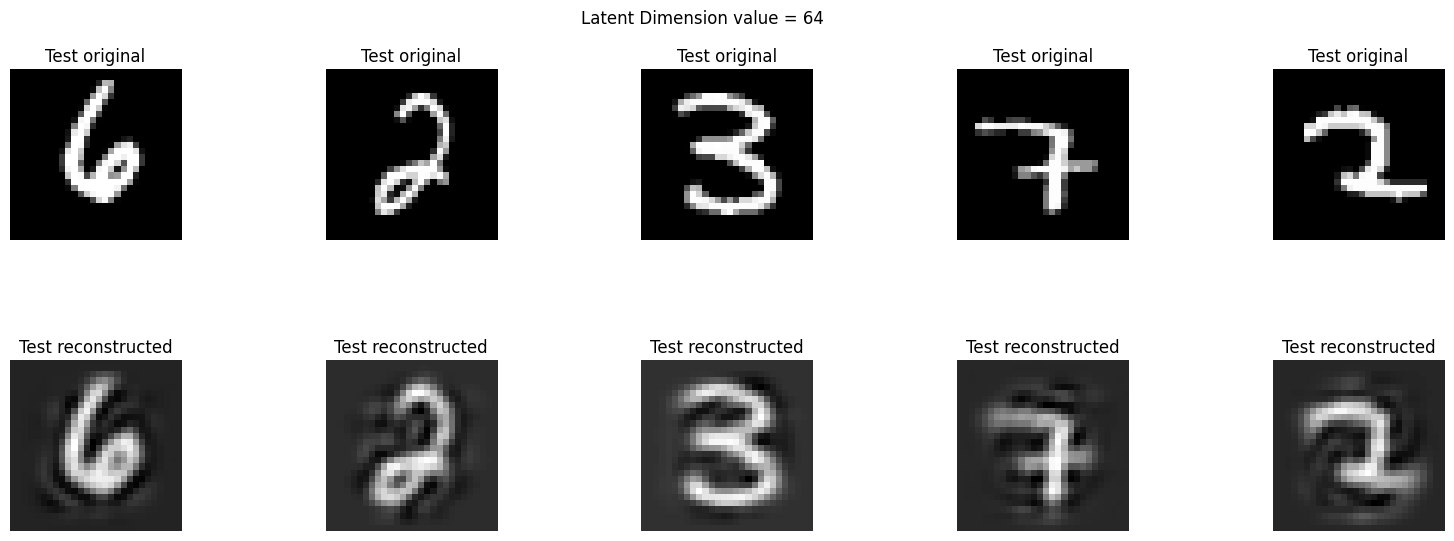

In [9]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

latentDimensions = [2, 4, 8, 16, 32, 64] 

def pcaFn(latentDimensionValue, flattenedTestImages):
    pca = PCA(n_components=latentDimensionValue)
    pca.fit(flattenedTrainImages)

    transformedImages = pca.inverse_transform(pca.transform(flattenedTestImages))
    transformedImages = transformedImages.reshape((-1, 28 * 28))    #Converting into 2d array

    return transformedImages

def pcaMSE(originalImages, reconstructedImages):
    return np.mean((originalImages - reconstructedImages)**2)

for latentDimensionValue in latentDimensions:

    reconstructedImages = pcaFn(latentDimensionValue, flattenedTestImages)
    mseVal = pcaMSE(flattenedTestImages,reconstructedImages)

    print("MSE for latent dimension {} is: {}".format(latentDimensionValue,mseVal))

    plt.figure(figsize=(20,6))
    plt.suptitle(f"Latent Dimension value = {latentDimensionValue}")

    for i, idx in enumerate(selectedImages):
        plt.subplot(2, 5, i + 1)
        plt.imshow(testImages[idx], cmap='gray')
        plt.title(f"Test original")
        plt.axis('off') #Removes x and y axis labels

        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructedImages[idx].reshape(28,28), cmap='gray')    #reshaping the 1d array back to 2d for accessing
        plt.title(f"Test reconstructed")
        plt.axis('off')

    plt.subplots_adjust(hspace=0.7, wspace=0.1)
    plt.show()



## PROBABILISTIC PCA IMPLEMENTATION

MSE val for latent dimension 2 is 0.06742457947489407


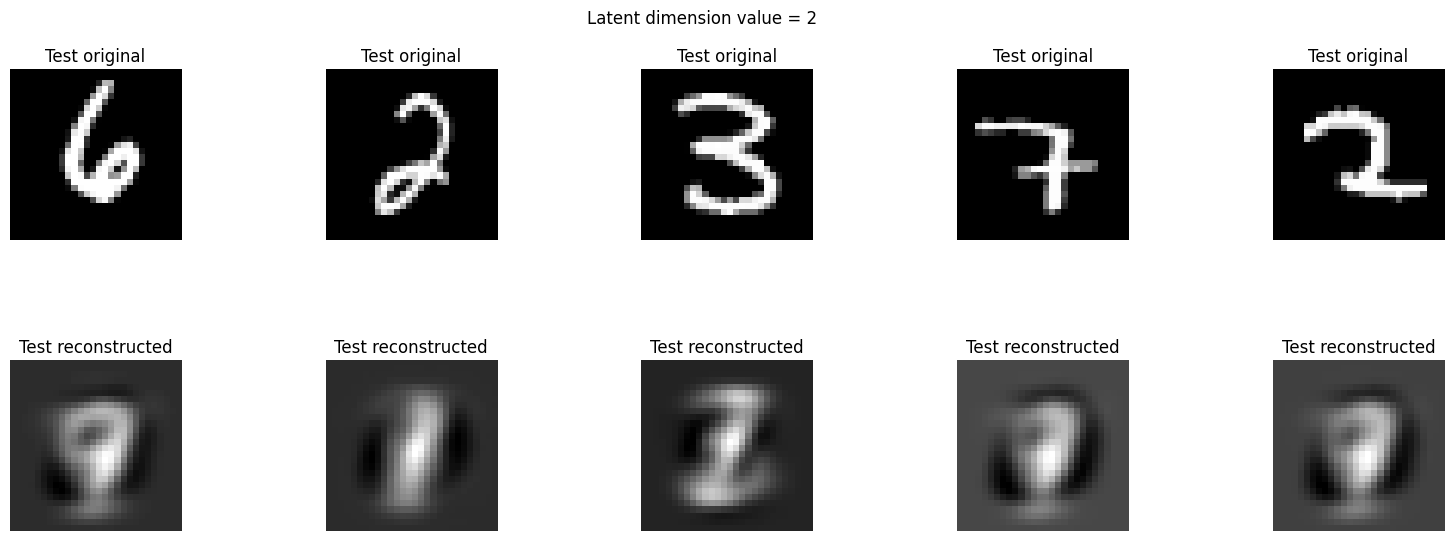

MSE val for latent dimension 4 is 0.06468975344922345


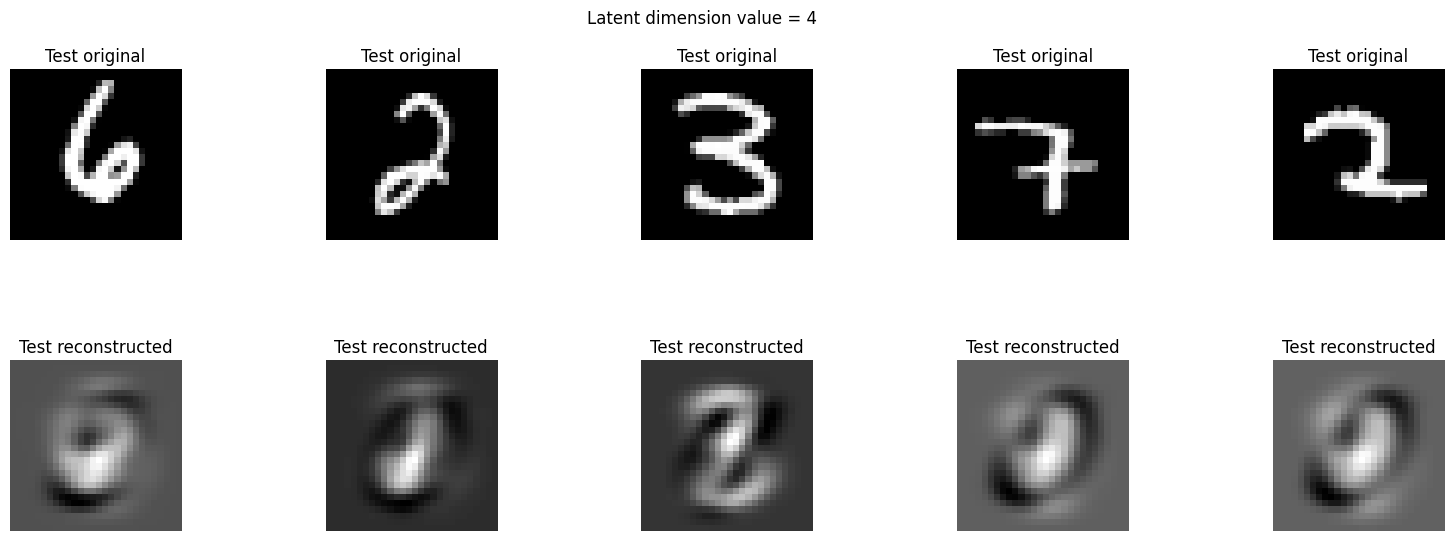

MSE val for latent dimension 8 is 0.07750603873774002


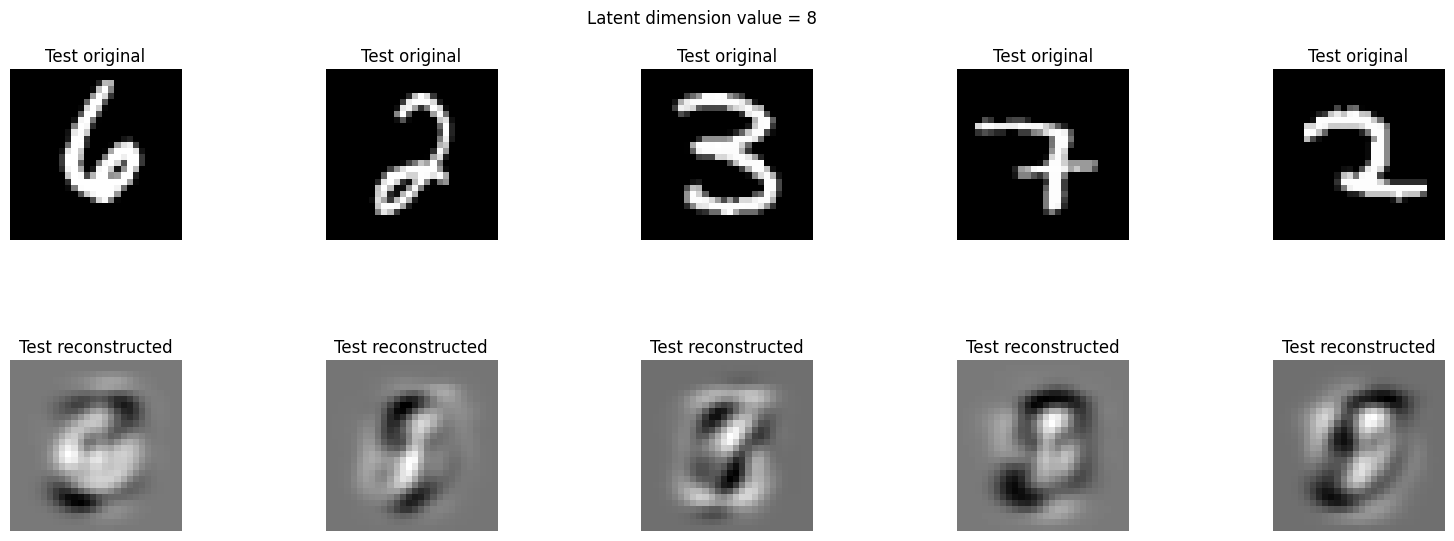

MSE val for latent dimension 16 is 0.07191685113844348


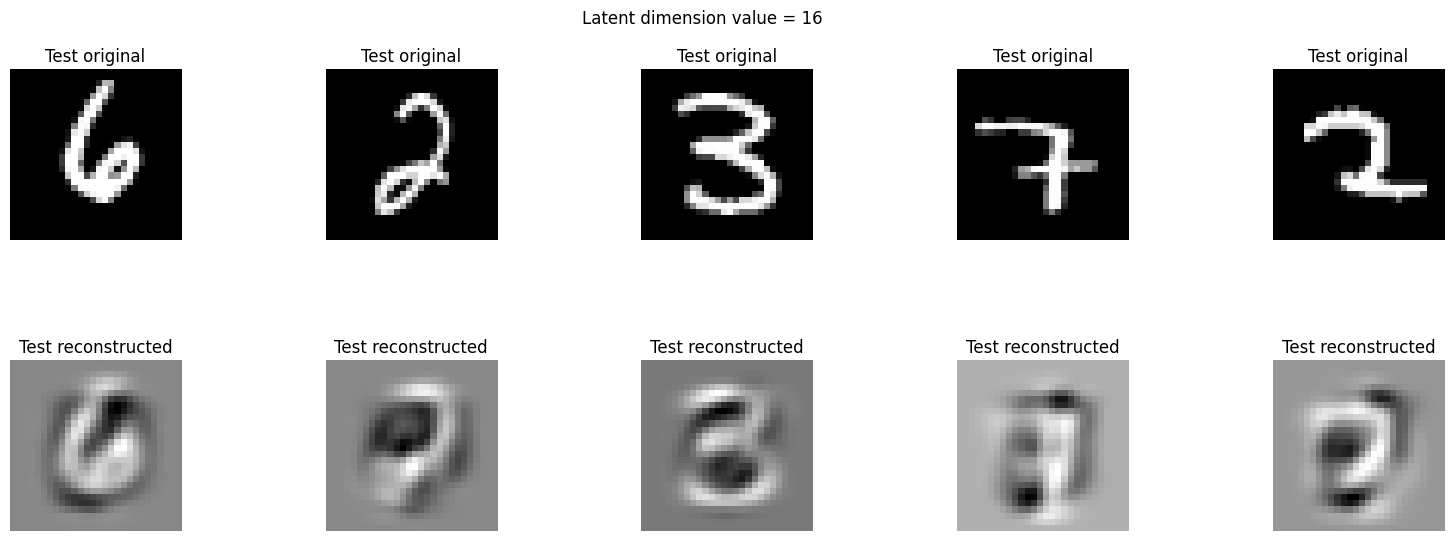

MSE val for latent dimension 32 is 0.06303978544636069


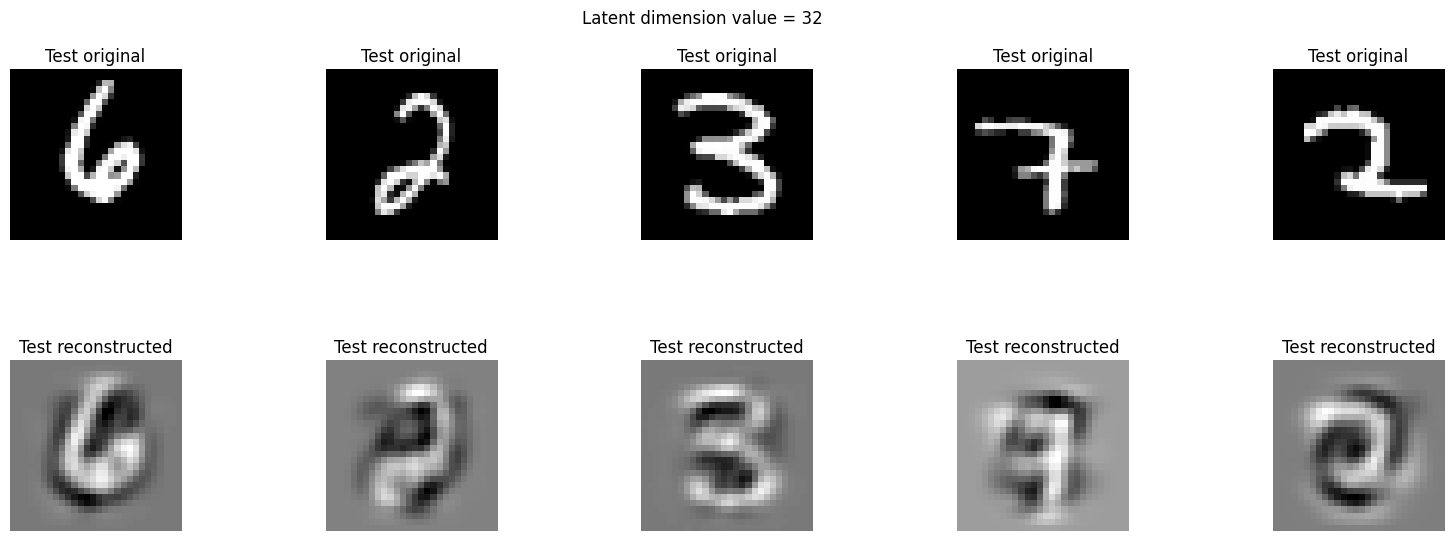

MSE val for latent dimension 64 is 0.055483935748384894


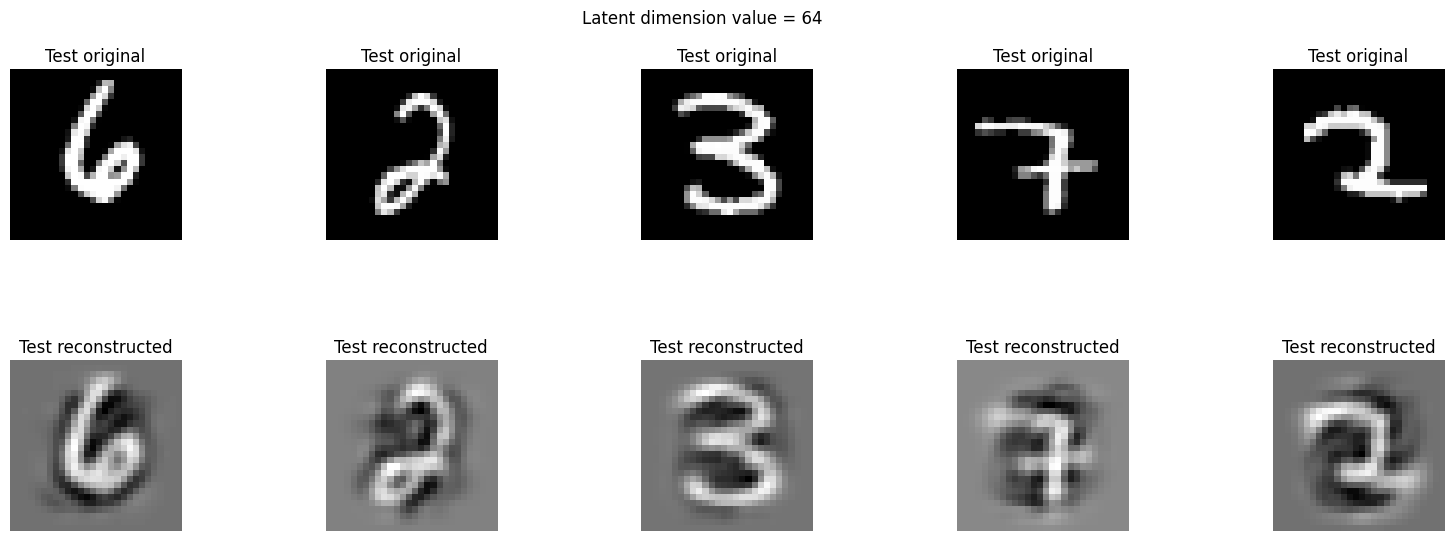

In [10]:
import matplotlib.pyplot as plt

latentDimensions = [2, 4, 8, 16, 32, 64]

def probabilisticPCA(centeredTrainImages, latentDimensionValue):
    '''numSamples = normalizedTrainImages.shape[0]
    trainMean = np.mean(normalizedTrainImages, axis = 0)
    covarianceMatrix = np.zeros((normalizedTrainImages.shape[1], normalizedTrainImages.shape[1]))
    imgCount = 0
    for image in normalizedTrainImages:
        imgCount = imgCount + 1
        print(imgCount)

        image = image.reshape(-1,1)
        covarianceMatrix += np.dot(image - trainMean, (image - trainMean.T))

    covarianceMatrix = covarianceMatrix / numSamples'''
    covarianceMatrix = (centeredTrainImages.T @ centeredTrainImages) / len(centeredTrainImages)

    #nan_indices = np.where(np.isnan(covarianceMatrix))
    #print("Indices with NaN in Covariance Matrix:", nan_indices)


    #print("Any NaN in Covariance Matrix:", np.any(np.isnan(covarianceMatrix)))       
    
    eigenValues, eigenVectors = np.linalg.eigh(covarianceMatrix)


    Um = eigenVectors[:, -latentDimensionValue:]    
    Lm = np.diag(eigenValues[-latentDimensionValue:])   #Diagonal matrix of eigenvalues

    I = np.eye(latentDimensionValue)
    sigmaSquare = (1 /  centeredTrainImages.shape[1] - latentDimensionValue) * np.sum(eigenValues[latentDimensionValue + 1:])
    R = I  # Since its arbitrary, we take R as an identity matrix
    
    weights = Um @ np.sqrt(abs(Lm - sigmaSquare * I)) @ R

    return weights

def imageReconstruction(testImages, weights, mean, sigma, latentDimensionValue):

    #Z, residuals, _, _ = np.linalg.lstsq(weights.T @ weights + 1e-5 * np.eye(weights.shape[1]), weights.T @ (normalizedImages - mean).T, rcond=None) 
    #print("Weights.T @ Weights:", weights.T @ weights)
    #print("Weights.T @ (normalizedImages - mean).T:", weights.T @ (normalizedImages - mean).T)

    #Z = np.linalg.solve((weights.T @ weights), (weights.T) @ (normalizedImages - mean).T) 
    #X = WZ + u
    #return (weights @ Z).T + mean

    M = weights.T @ weights + sigma**2 * np.eye(latentDimensionValue)

    z = (np.linalg.inv(M) @ weights.T @ (testImages - mean).T)

    K = (weights @ (np.linalg.inv(weights.T @ weights)) @ M @ z).T
    x_pred = K + mean.reshape(-1,1).T
    return x_pred

trainMean = np.mean(flattenedTrainImages, axis = 0)
#standardDev = np.std(flattenedTrainImages, axis = 0)
#N = flattenedTrainImages.shape[0]
#D = flattenedTrainImages.shape[1]
sigma = np.std(flattenedTestImages)
testMean = np.mean(flattenedTestImages, axis = 0)

centeredTrainImages = flattenedTrainImages - trainMean
centeredTestImages = (flattenedTestImages - testMean)

for latentDimensionValue in latentDimensions:

     
    weights = probabilisticPCA(centeredTrainImages, latentDimensionValue)
    reconstructedImages = imageReconstruction(centeredTestImages, weights, testMean, sigma, latentDimensionValue) 
    mseSum = 0

    plt.figure(figsize=(20,6))
    plt.suptitle(f"Latent dimension value = {latentDimensionValue}")
    #print(reconstructedImages.shape)
    
    for idx in range(len(centeredTestImages)):
        #print(normalizedTestImages[idx])
        #print(reconstructedImage)
        mseVal = np.mean((flattenedTestImages[idx] - reconstructedImages[idx])**2)
        mseSum += mseVal
        
    finalMse = (mseSum) / len(centeredTestImages)
    print("MSE val for latent dimension {} is {}".format(latentDimensionValue,finalMse))

    for i, idx in enumerate(selectedImages):
        plt.subplot(2, 5, i + 1)
        plt.imshow(flattenedTestImages[idx].reshape(28,28), cmap='gray')
        plt.title(f"Test original")
        plt.axis('off') #Removes x and y axis labels

        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructedImages[idx].reshape(28,28), cmap='gray')    #reshaping the 1d array back to 2d for accessing
        plt.title(f"Test reconstructed")
        plt.axis('off')

    plt.subplots_adjust(hspace=0.7, wspace=0.1)
    plt.show()

## VARIATIONAL AUTOENCODER

Epoch 1/10
600/600 [==============================] - 4s 6ms/step - loss: 197.6796 - val_loss: 165.4904
Epoch 2/10
600/600 [==============================] - 3s 5ms/step - loss: 161.6372 - val_loss: 157.3711
Epoch 3/10
600/600 [==============================] - 3s 5ms/step - loss: 155.7609 - val_loss: 153.5618
Epoch 4/10
600/600 [==============================] - 3s 5ms/step - loss: 152.6125 - val_loss: 150.6313
Epoch 5/10
600/600 [==============================] - 3s 6ms/step - loss: 150.4593 - val_loss: 150.3062
Epoch 6/10
600/600 [==============================] - 4s 7ms/step - loss: 148.8361 - val_loss: 148.1265
Epoch 7/10
600/600 [==============================] - 4s 6ms/step - loss: 147.5862 - val_loss: 147.4572
Epoch 8/10
600/600 [==============================] - 4s 6ms/step - loss: 146.6321 - val_loss: 145.9977
Epoch 9/10
600/600 [==============================] - 3s 6ms/step - loss: 145.4432 - val_loss: 145.3235
Epoch 10/10
313/313 [==============================] - 0s 666us/

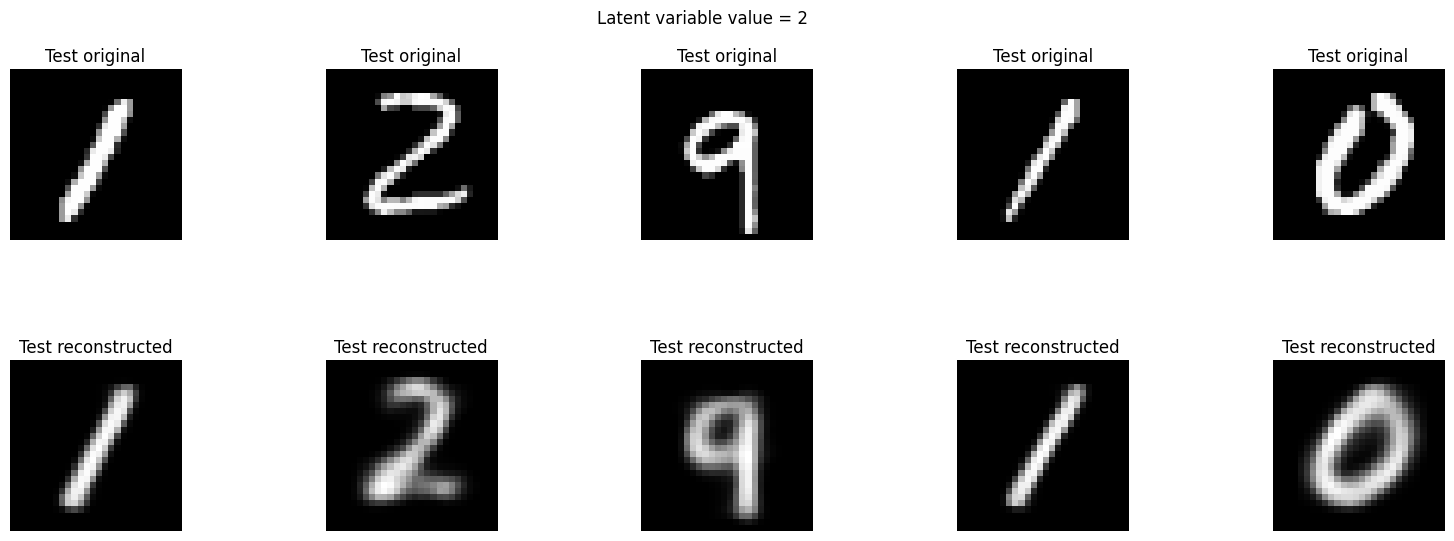

Epoch 1/10
600/600 [==============================] - 4s 5ms/step - loss: 167.7175 - val_loss: 144.2417
Epoch 2/10
600/600 [==============================] - 4s 6ms/step - loss: 139.4790 - val_loss: 135.1754
Epoch 3/10
600/600 [==============================] - 3s 5ms/step - loss: 133.7604 - val_loss: 131.2609
Epoch 4/10
600/600 [==============================] - 3s 6ms/step - loss: 130.2949 - val_loss: 128.6658
Epoch 5/10
600/600 [==============================] - 3s 5ms/step - loss: 127.9429 - val_loss: 126.8784
Epoch 6/10
600/600 [==============================] - 4s 6ms/step - loss: 126.2176 - val_loss: 125.2433
Epoch 7/10
600/600 [==============================] - 4s 7ms/step - loss: 124.8303 - val_loss: 124.8282
Epoch 8/10
600/600 [==============================] - 4s 7ms/step - loss: 123.7257 - val_loss: 123.1873
Epoch 9/10
600/600 [==============================] - 4s 7ms/step - loss: 122.7721 - val_loss: 123.0508
Epoch 10/10
313/313 [==============================] - 0s 740us/

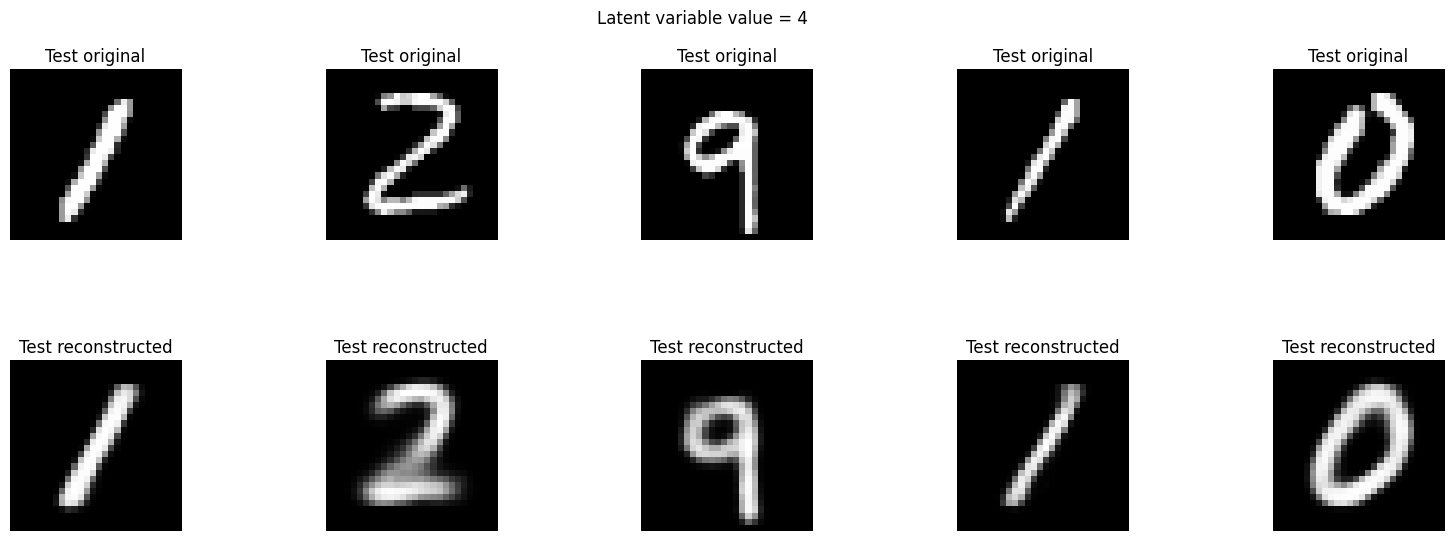

Epoch 1/10
600/600 [==============================] - 4s 6ms/step - loss: 165.5333 - val_loss: 134.9214
Epoch 2/10
600/600 [==============================] - 4s 6ms/step - loss: 127.0987 - val_loss: 120.5131
Epoch 3/10
600/600 [==============================] - 4s 6ms/step - loss: 117.8781 - val_loss: 113.3575
Epoch 4/10
600/600 [==============================] - 4s 6ms/step - loss: 113.3917 - val_loss: 111.3074
Epoch 5/10
600/600 [==============================] - 4s 6ms/step - loss: 110.5404 - val_loss: 108.2686
Epoch 6/10
600/600 [==============================] - 4s 7ms/step - loss: 108.4693 - val_loss: 107.0741
Epoch 7/10
600/600 [==============================] - 4s 6ms/step - loss: 106.8975 - val_loss: 105.6595
Epoch 8/10
600/600 [==============================] - 4s 6ms/step - loss: 105.6765 - val_loss: 105.1537
Epoch 9/10
600/600 [==============================] - 4s 7ms/step - loss: 104.6545 - val_loss: 104.4883
Epoch 10/10
313/313 [==============================] - 0s 652us/

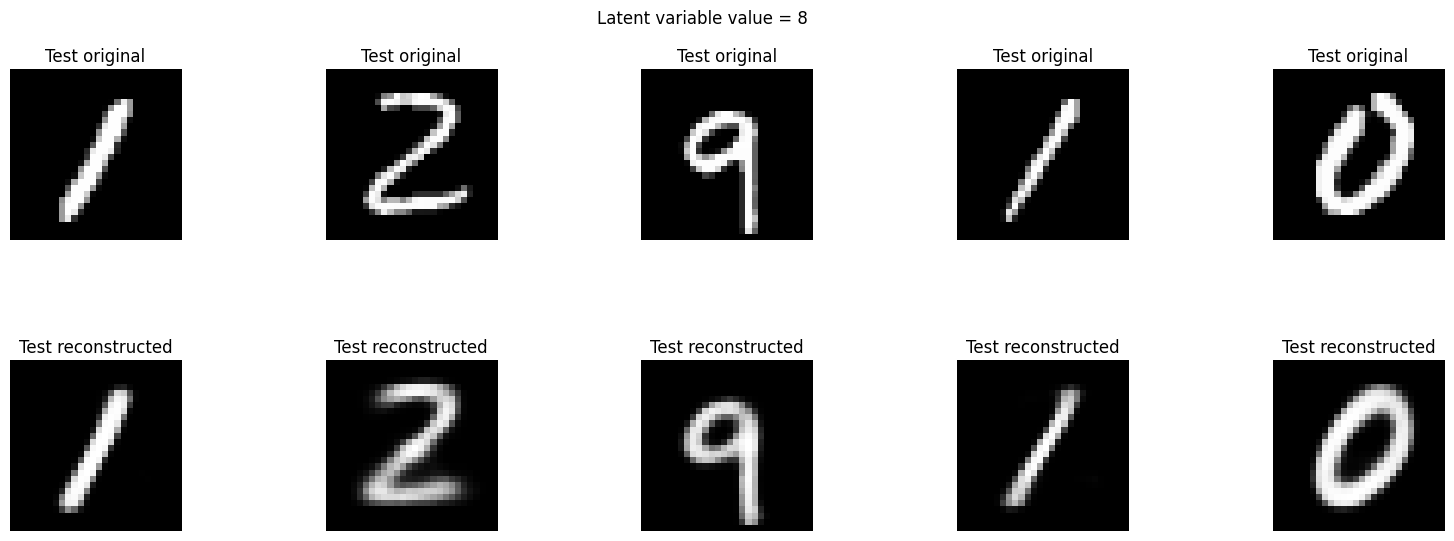

Epoch 1/10
600/600 [==============================] - 5s 7ms/step - loss: 162.4180 - val_loss: 129.0353
Epoch 2/10
600/600 [==============================] - 3s 5ms/step - loss: 122.9216 - val_loss: 115.2951
Epoch 3/10
600/600 [==============================] - 3s 5ms/step - loss: 112.8233 - val_loss: 107.8898
Epoch 4/10
600/600 [==============================] - 3s 5ms/step - loss: 106.9152 - val_loss: 103.5340
Epoch 5/10
600/600 [==============================] - 3s 5ms/step - loss: 103.4416 - val_loss: 101.4957
Epoch 6/10
600/600 [==============================] - 4s 7ms/step - loss: 101.2529 - val_loss: 100.2296
Epoch 7/10
600/600 [==============================] - 4s 6ms/step - loss: 99.6279 - val_loss: 98.0821
Epoch 8/10
600/600 [==============================] - 4s 6ms/step - loss: 98.4022 - val_loss: 97.0573
Epoch 9/10
600/600 [==============================] - 4s 6ms/step - loss: 97.4169 - val_loss: 96.5689
Epoch 10/10
313/313 [==============================] - 0s 694us/step
M

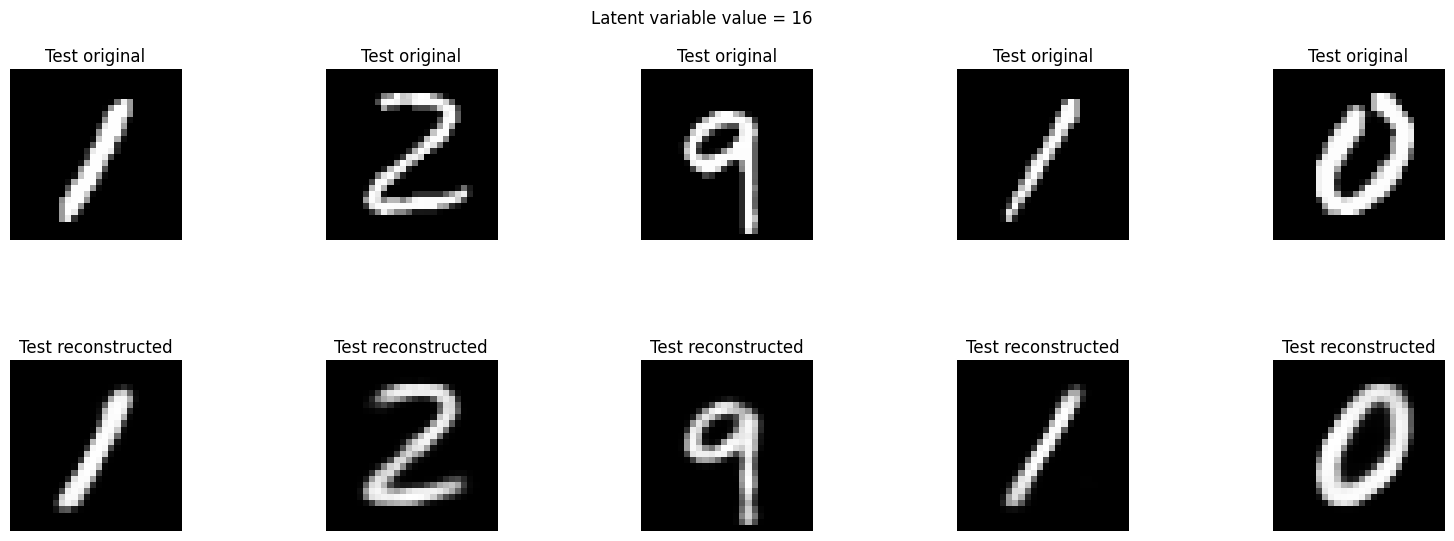

Epoch 1/10
600/600 [==============================] - 4s 6ms/step - loss: 163.6632 - val_loss: 135.7561
Epoch 2/10
600/600 [==============================] - 4s 6ms/step - loss: 125.6498 - val_loss: 115.8635
Epoch 3/10
600/600 [==============================] - 4s 6ms/step - loss: 114.0390 - val_loss: 109.5805
Epoch 4/10
600/600 [==============================] - 4s 7ms/step - loss: 107.8328 - val_loss: 105.0289
Epoch 5/10
600/600 [==============================] - 4s 7ms/step - loss: 104.0017 - val_loss: 101.1926
Epoch 6/10
600/600 [==============================] - 4s 7ms/step - loss: 101.3662 - val_loss: 101.4032
Epoch 7/10
600/600 [==============================] - 4s 6ms/step - loss: 99.4993 - val_loss: 99.3412
Epoch 8/10
600/600 [==============================] - 4s 6ms/step - loss: 98.1173 - val_loss: 96.8689
Epoch 9/10
600/600 [==============================] - 4s 6ms/step - loss: 97.0852 - val_loss: 96.8039
Epoch 10/10
313/313 [==============================] - 0s 723us/step
M

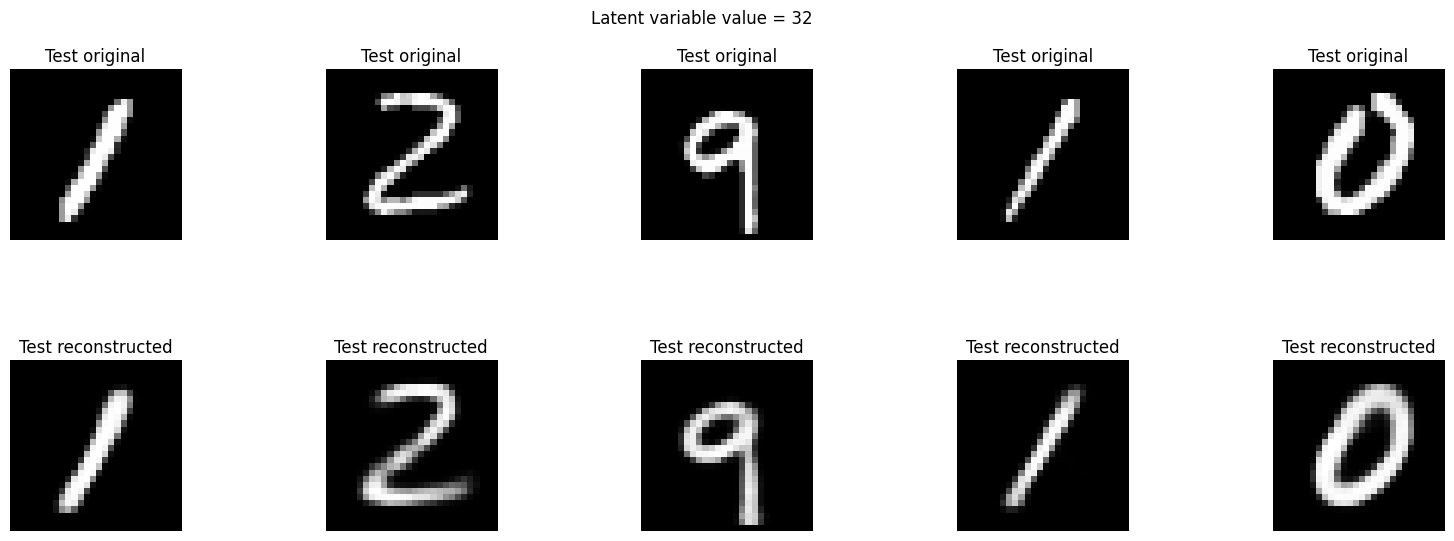

Epoch 1/10
600/600 [==============================] - 4s 7ms/step - loss: 166.6809 - val_loss: 139.3026
Epoch 2/10
600/600 [==============================] - 4s 7ms/step - loss: 129.9122 - val_loss: 120.0492
Epoch 3/10
600/600 [==============================] - 4s 7ms/step - loss: 117.2110 - val_loss: 112.3436
Epoch 4/10
600/600 [==============================] - 4s 6ms/step - loss: 110.2985 - val_loss: 106.2662
Epoch 5/10
600/600 [==============================] - 4s 6ms/step - loss: 105.8476 - val_loss: 103.1652
Epoch 6/10
600/600 [==============================] - 4s 6ms/step - loss: 102.8224 - val_loss: 102.0596
Epoch 7/10
600/600 [==============================] - 4s 6ms/step - loss: 100.6813 - val_loss: 97.7234
Epoch 8/10
600/600 [==============================] - 4s 6ms/step - loss: 99.0997 - val_loss: 97.2167
Epoch 9/10
600/600 [==============================] - 4s 6ms/step - loss: 97.8713 - val_loss: 97.2088
Epoch 10/10
313/313 [==============================] - 0s 683us/step


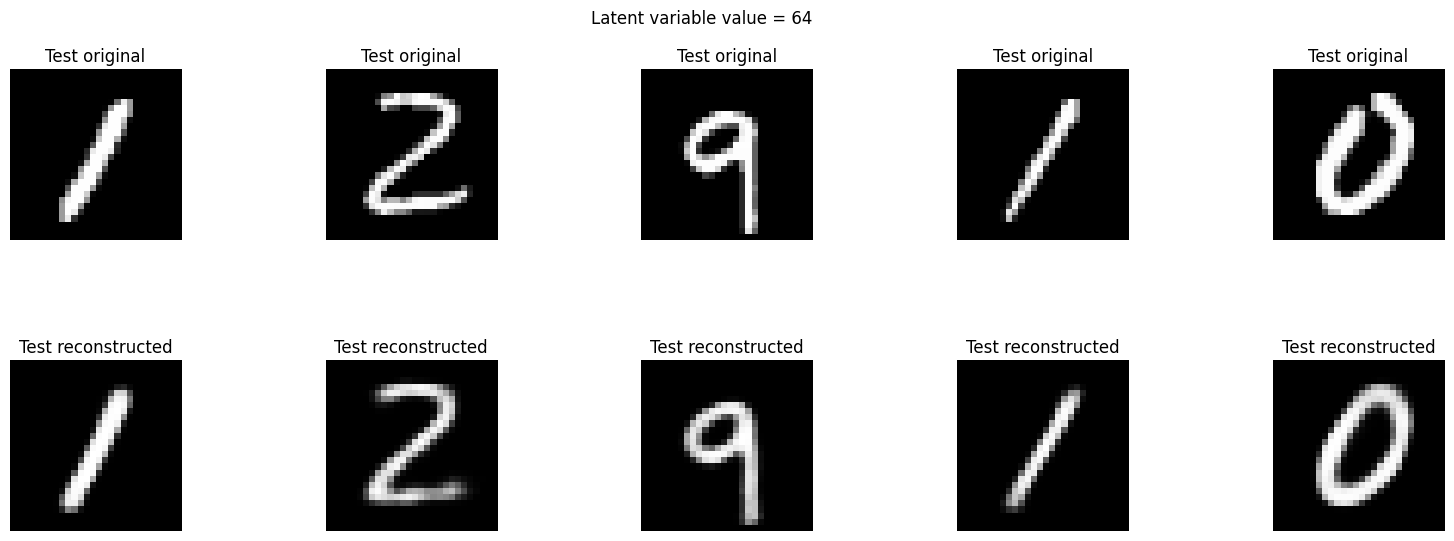

In [11]:
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from scipy.stats import norm

latentDimensions = [2, 4, 8, 16, 32, 64]
# latentDimensions = [2]
randomImages = random.sample(range(len(testImages)), 5)

batch_size, epoch = 100, 10
n_hidden = 256

def normalization(flattenedTrainImages):
    mean = np.mean(flattenedTrainImages, axis = 0)
    standardDev = np.std(flattenedTrainImages, axis = 0)

    #Handle 0 variance here, else NaN values are produced
    zeroVarianceIndices = np.where(standardDev == 0)[0]
    standardDev[zeroVarianceIndices] = 1e-5

    normalizedImages = (flattenedTrainImages - mean) / standardDev
    return normalizedImages, mean, standardDev

def variationalAutoEncoder(flattenedTrainImages, flattenedTestImages, latentDimensionValue):
    
    x = Input(shape=(flattenedTrainImages.shape[1:]))
    h1 = Dense(256, activation='relu')(x)
    h1 = Dense(128, activation='relu')(h1)

    mu = Dense(latentDimensionValue)(h1)
    log_var = Dense(latentDimensionValue)(h1)

    def sampling(args):
        mu, log_var = args
        eps = K.random_normal(shape=(batch_size, latentDimensionValue), mean=0., stddev=1.0)
        return mu + K.exp(log_var) * eps

    z = Lambda(sampling, output_shape=(latentDimensionValue,))([mu, log_var])

    z1 = Dense(128, activation='relu')
    z2 = Dense(256, activation='relu')
    y_decoder = Dense(flattenedTrainImages.shape[1], activation='sigmoid')

    h2 = z1(z)
    h2 = z2(h2)
    y = y_decoder(h2)

    kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
    reconstruction_loss = K.sum(K.binary_crossentropy(x, y), axis=-1)

    vae_loss = reconstruction_loss + kl_loss

    vae = Model(x, y)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')

    vae.fit(flattenedTrainImages,epochs=epoch,batch_size=batch_size,validation_data=(flattenedTestImages, None), verbose=1)

    encoder = Model(x, mu)
    z_latent = encoder.predict(flattenedTestImages, batch_size=batch_size)

    decoder_input = Input(shape=(latentDimensionValue,))
    h3 = z1(decoder_input)
    h3 = z2(h3)
    generatedImage = y_decoder(h3)
    generator = Model(decoder_input, generatedImage)

    reconstructed = generator.predict(z_latent)
    
    return reconstructed


normalizedTrainImages, mean, standardDev = normalization(flattenedTrainImages)

for latentDimensionValue in latentDimensions:

    normalizedTestImages = (flattenedTestImages - mean) / standardDev
    reconstructedImages = variationalAutoEncoder(flattenedTrainImages, flattenedTestImages, latentDimensionValue)
    mseVal = np.mean(np.square(flattenedTestImages - reconstructedImages))

    print("MSE for latent dimension {} is: {}".format(latentDimensionValue,mseVal))

    plt.figure(figsize=(20,6))
    plt.suptitle(f"Latent variable value = {latentDimensionValue}")

    for i, idx in enumerate(randomImages):
        plt.subplot(2, 5, i + 1)
        plt.imshow(testImages[idx], cmap='gray')
        plt.title(f"Test original")
        plt.axis('off') #Removes x and y axis labels

        plt.subplot(2, 5, i + 6)
        # reconstructed_image_np = reconstructedImages[idx].numpy()
        plt.imshow(reconstructedImages[idx].reshape(28,28), cmap='gray')
        plt.title(f"Test reconstructed")
        plt.axis('off')

    plt.subplots_adjust(hspace=0.7, wspace=0.1)
    plt.show()